In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings

warnings.filterwarnings("ignore")
os.chdir("../")

### read in all trades files and concate to one dataframe
from analysis import single_trade_files_to_one
single_trade_files_to_one().to_csv("historic_data/trades.csv")

### transform trades to usable profits dataframe
from analysis import format_trades_df, get_trade_count, calculate_profits
nft_trades = pd.read_csv("historic_data/trades.csv", low_memory=False)
nft_trades.pipe(format_trades_df).pipe(get_trade_count).pipe(calculate_profits).to_csv("historic_data/profits.csv")

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from analysis import *
from sklearn.cluster import KMeans

In [4]:
trades = load_trades()

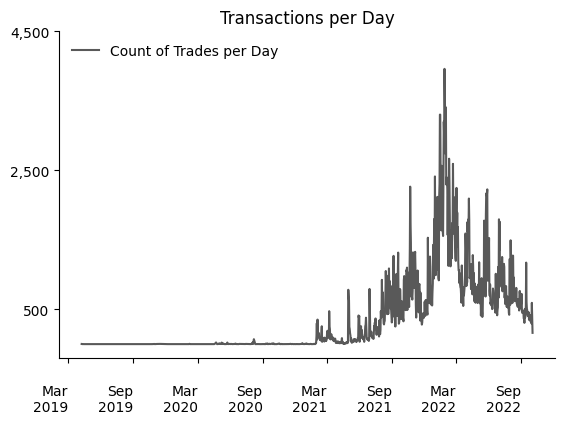

In [18]:
plot_count_trades_per_day(trades)

In [4]:
trades.head()

,date,nft_id,price_eth,price_usd,collection,Buyer,txn_hash
0,2021-03-14,0xmons.xyz_103,6.00,11092.14,0xmons.xyz,0xfaf1031b02a994b80f12cc1ee4c0dcebbb946aa0,0xb4f8ec6ac9cd76de994c2912923ea09e0094be165913...
1,2021-08-01,0xmons.xyz_103,5.00,12782.05,0xmons.xyz,0x73ffce54ce7d21397a7932d9bc2a7e013ff30902,0x8a3fb6eec565e1f997881ea2b40bd778f21cf3f50fd8...
2,2021-04-01,0xmons.xyz_118,7.99,15721.68,0xmons.xyz,0x2117c37a65ad3c0489682386f7d81d4c6d08b3c8,0xa8cf0256bfcf5359365bd360f94cd6f76ba52c0b2053...
3,2021-12-04,0xmons.xyz_118,12.00,49491.12,0xmons.xyz,0x947e1bbcbf8a67a9f7a393adf93179baaf0cccdc,0xbccbf4cae59258731825c74cf7cad7243663732bfb77...
4,2021-03-11,0xmons.xyz_126,5.55,10140.18,0xmons.xyz,0xfaf1031b02a994b80f12cc1ee4c0dcebbb946aa0,0xaf9ca732b6ee7f0814705b68e814ce5e2e30d534ae8e...


In [3]:
nft_trades = load_nft_trades()

In [6]:
describe_series(nft_trades["holding_period"])

\begin{tabular}{ll}
\toprule
{} &  holding\_period \\
\midrule
Count           &          272978 \\
Total Value     &        10741566 \\
Median          &            12.0 \\
Mean            &       39.349567 \\
Std. Dev.       &       61.095141 \\
Min. Value      &               0 \\
Max. Value      &            1110 \\
Min. Collection &  0xmons.xyz\_157 \\
Max. Collection &  Autoglyphs\_292 \\
\bottomrule
\end{tabular}



In [7]:
hp_correl_profit = nft_trades["holding_period"].corr(nft_trades["profit_usd"])

In [8]:
hp_correl_profit

0.011342925388377613

In [9]:
nft_trades["holding_period"]

nft_id          trade_no
0xmons.xyz_103  1           140
0xmons.xyz_118  1           247
0xmons.xyz_126  1           149
0xmons.xyz_127  1            42
0xmons.xyz_129  1           209
                           ... 
merge._9699     1            13
merge._9700     1           105
merge._9706     1             0
merge._9780     1             0
merge._9956     1             0
Name: holding_period, Length: 272978, dtype: int64

In [10]:
nft_trades[nft_trades.profit_usd > 100000]

,,purchase_date,sell_date,holding_period,purchase_price_eth,sell_price_eth,profit_eth,purchase_price_usd,sell_price_usd,profit_usd,collection,from_address,to_address,purchase_hash,sell_hash
nft_id,trade_no,,,,,,,,,,,,,,
Autoglyphs_271,1,2020-09-15,2021-05-01,228,0.005263,90.0,17099.0,1.92,265302.00,138177.125000,Autoglyphs,0xf2e4a3639b7dc9c7084ae59f7c511a9a1f807d1e,0x0ecd8a50ce988862dc0e69a669159036e88ea649,0x6bc6a906a8d40da0b940b2485e8baca123d4a5aaef0b...,0x68e1d83758aa4fe8d54eaa33f4dd46e13db2efeededf...
BoredApeYachtClub_2276,3,2021-10-07,2022-02-04,120,0.000500,183.0,365999.0,1.79,548483.94,306414.608939,BoredApeYachtClub,0xe749990bdf5c1ad4e182cc27c016b478f259a909,0x5ac7983a4faafbee0150a8bf8100960887f1b102,0x45020200bc080d067c4e0fe909815e95c71dfc224540...,0xf02fff87dfa6aeee79fe66371efdda0db66b05ab7c4e...


In [11]:
df = trades[["collection", "date", "nft_id"]].sort_values(["collection", "date"])

In [12]:
df

,collection,date,nft_id
103,0xmons.xyz,2021-02-01,0xmons.xyz_62
24,0xmons.xyz,2021-02-10,0xmons.xyz_16
10,0xmons.xyz,2021-02-18,0xmons.xyz_134
104,0xmons.xyz,2021-02-18,0xmons.xyz_62
56,0xmons.xyz,2021-02-19,0xmons.xyz_24
...,...,...,...
436059,merge.,2022-10-02,merge._19674
436277,merge.,2022-10-02,merge._21852
437084,merge.,2022-10-02,merge._7457
437085,merge.,2022-10-02,merge._7457


In [13]:
df_list = []
for collection in df.collection.unique():
    collection_df = df[df["collection"] == collection].reset_index(drop=True)
    collection_df["date"] = pd.to_datetime(collection_df["date"]).dt.date
    first_date = collection_df.iloc[0]["date"]
    last_date = collection_df.iloc[-1]["date"]
    trades_per_day = collection_df[["date", "nft_id"]].groupby("date").count()
    transaction_range = pd.to_datetime(
        pd.date_range(start=first_date, end=last_date)
    ).date
    day_count = pd.DataFrame(transaction_range, columns=["date"])
    i = 0
    day_count = (
        day_count.set_index("date")
        .merge(trades_per_day, how="left", left_index=True, right_index=True)
        .rename(columns={"nft_id": collection})
        .reset_index()
    )
    df_list.append(day_count.drop("date", axis=1))
all_collections_all_dates = pd.concat(df_list)

In [14]:
trades_per_day = (
    all_collections_all_dates.sort_index()
    .reset_index()
    .melt("index")
    .dropna()
    .sort_values("index")
    .pivot_table(index="index", columns="variable", values="value")
    .fillna(0)
)

In [15]:
trades_per_day.mean(axis=1)[:10].sum() / trades_per_day.mean(axis=1)[10:].sum()

0.5129972832199899

In [17]:
pd.date_range(start=first_date, end=last_date)

DatetimeIndex(['2021-12-15', '2021-12-16', '2021-12-17', '2021-12-18',
               '2021-12-19', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-24',
               ...
               '2022-09-23', '2022-09-24', '2022-09-25', '2022-09-26',
               '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30',
               '2022-10-01', '2022-10-02'],
              dtype='datetime64[ns]', length=292, freq='D')

In [18]:
pd.DataFrame(index=transaction_range)

""
2021-12-15
2021-12-16
2021-12-17
2021-12-18
2021-12-19
...
2022-09-28
2022-09-29
2022-09-30
2022-10-01


In [19]:
trades_per_day = collection_df["nft_id"].groupby("date").count()

KeyError: 'date'

In [ ]:
trades_per_day

In [ ]:
test = pd.DataFrame(index=transaction_range)

In [ ]:
for date in test.index:
    df["trade_count"] = collection_df[collection_df["date"]=first_date]

In [ ]:
count_dict = {}
for collection in df.collection.unique():
    collection_df = df[df["collection"] == collection].reset_index()
    first_date = collection_df.iloc[0]["date"]
    first_date_df = collection_df[collection_df["date"] == first_date]
    count_first_date = first_date_df.nft_id.count()
    rest_df = collection_df[collection_df["date"] != first_date]
    count_rest = collection_df.nft_id.count()
    first_rest_ration = count_first_date / (count_first_date + count_rest)
    count_dict[collection] = first_rest_ration

In [ ]:
pd.DataFrame.from_dict(
    count_dict, columns=["percentage_first_day_trades"], orient="index"
).mean()

In [ ]:
trades[["collection", "nft_id"]].drop_duplicates().groupby(
    "collection"
).count().median()

In [ ]:
marketcap_collection = trades[["collection", "price_usd"]].groupby("collection").sum()
count_collection = trades[["collection", "price_usd"]].groupby("collection").count()

In [ ]:
count_collection

In [ ]:
count_collection["price_usd"].median()

In [ ]:
marketcap_collection.sort_values("price_usd").iloc[0]

In [ ]:
marketcap_collection.sort_values("price_usd").iloc[-1]

In [20]:
marketcap_collection.max()

NameError: name 'marketcap_collection' is not defined

In [72]:
nft_trades["usd_eth_dif"] = nft_trades["profit_usd"] - nft_trades["profit_eth"]

In [22]:
nft_trades["usd_eth_dif"].median()

-0.002857079590964706

In [ ]:
nft_trades[nft_trades["usd_eth_dif"] == nft_trades["usd_eth_dif"].max()]

In [ ]:
nft_trades[nft_trades["usd_eth_dif"] == nft_trades["usd_eth_dif"].max()]["sell_hash"][0]

AttributeError: module 'matplotlib.pyplot' has no attribute 'layout'

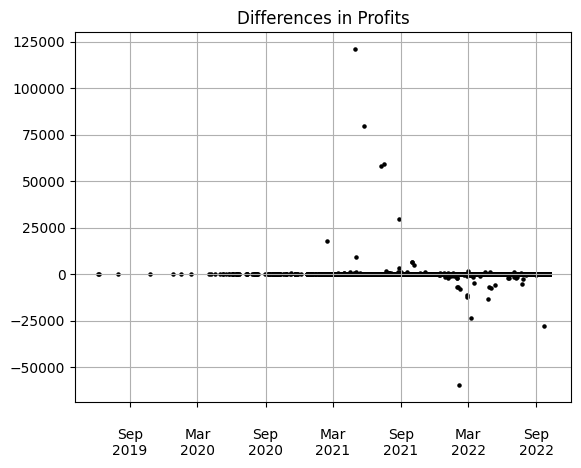

In [76]:
nft_trades["usd_eth_dif"] = nft_trades["profit_usd"] - nft_trades["profit_eth"]

ax = nft_trades.plot.scatter(
    x="sell_date",
    y="usd_eth_dif",
    marker=".",
    grid=True,
    color="black",
    logy=False,
    ylabel="",
    xlabel="",
    title=f"Differences in Profits",
)
ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ",")))
plt.tight_layout()
plt.savefig("figures/eth_usd_dif.png")
plt.show()

In [ ]:
nft_trades = load_nft_trades()
get_counts(nft_trades)

In [ ]:
nft_trades[nft_trades["profit_usd"] > 0]["profit_usd"].count() / nft_trades[
    "profit_usd"
].count()

In [ ]:
nft_trades[nft_trades["profit_eth"] > 0]["profit_eth"].count() / nft_trades[
    "profit_eth"
].count()

In [ ]:
nft_trades[nft_trades["profit_usd"] >= 100]["profit_usd"].count() / nft_trades[
    "profit_usd"
].count()

In [ ]:
nft_trades.reset_index()[nft_trades.reset_index()["trade_no"] == 1]["profit_usd"].mean()

In [ ]:
nft_trades.reset_index()[nft_trades.reset_index()["trade_no"] == 2]["profit_usd"].mean()

# Create NFT Index

In [ ]:
# Profit per day
nft_trades["profit_usd_per_day"] = nft_trades["profit_usd"] / (
    1 + nft_trades["holding_period"]
)

# Get Floor Price per collection per day
floor_price_collections = (
    nft_trades[["sell_date", "sell_price_usd", "collection"]]
    .pivot_table(
        columns="collection", index="sell_date", values="sell_price_usd", aggfunc="min"
    )
    .fillna(0)
)

# Daily market cap
collection_turnover_sum = (
    nft_trades[["sell_date", "sell_price_usd", "collection"]]
    .pivot_table(
        columns="collection", index="sell_date", values="sell_price_usd", aggfunc="sum"
    )
    .fillna(0)
)

# Daily profit per day
collection_profit_per_day = (
    nft_trades[["sell_date", "profit_usd_per_day", "collection"]]
    .pivot_table(
        columns="collection",
        index="sell_date",
        values="profit_usd_per_day",
        aggfunc="sum",
    )
    .fillna(0)
)

# Daily rel market cap per collection
collection_rel_mkt_cap = collection_turnover_sum.div(
    collection_turnover_sum.sum(axis=1), axis=0
)

nft_index_collections = collection_rel_mkt_cap * floor_price_collections
nft_index = pd.DataFrame(nft_index_collections.mean(axis=1), columns=["nft_index"])
nft_index = nft_index / nft_index.iloc[0]["nft_index"]

In [ ]:
spx = pd.read_csv("historic_data/spx.csv")
spx = spx.assign(Date=pd.to_datetime(spx.Date)).set_index("Date")

In [ ]:
eth_usd = pd.read_csv("historic_data/eth_usd.csv")
eth_usd = eth_usd.assign(Date=pd.to_datetime(eth_usd.Date)).set_index("Date")

In [ ]:
ax = eth_usd.rename(columns={"ETH_in_USD": "ETH/USD"}).plot(
    grid=True, color="black", title="Price History of Cryptocurrency Ether (ETH)"
)
ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
plt.savefig("figures/eth_history.png")
plt.show()

In [ ]:
eth_usd

In [ ]:
nft_index_plot = nft_index.loc["2021-01-01":]
spx_plot = spx.loc["2021-01-01":]
ax = (nft_index_plot / 1).plot()
ax1 = ax.twinx()
(spx_plot / 1).plot(ax=ax1, color="orange")

In [ ]:
matrix = (
    nft_index_plot.merge(spx_plot, how="left", left_index=True, right_index=True)
    .merge(eth_usd, how="inner", left_index=True, right_index=True)
    .rename(
        columns={"nft_index": "NFT Index", "spx": "S&P 500", "ETH_in_USD": "ETH Price"}
    )
)
correl_matrix = matrix.corr()

In [ ]:
matrix

In [ ]:
plot_correl_heatmap(correl_matrix)

# Analyse NFT Trades

In [78]:
trades = load_trades()

In [96]:
from datetime import datetime

In [98]:
ax = (
    trades[["date", "price_usd"]]
    .rename(columns={"price_usd": "Million US-Dollar"})
    .groupby("date")
    .sum()
    .loc[datetime(2021, 1,1).date:]
    .plot(
        grid=True,
        logy=False,
        title="Total NFT Art Trading Volume",
        color="black",
        xlabel=""
    )
)
ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
plt.gca().yaxis.set_major_formatter(
    FuncFormatter(lambda x, p: format(int(x / 1000000), ","))
)
plt.savefig("figures/trading_volume.png")
plt.show()

TypeError: '<' not supported between instances of 'builtin_function_or_method' and 'builtin_function_or_method'

In [ ]:
plot_count_trades_per_day(trades)

In [56]:
from matplotlib.ticker import FuncFormatter

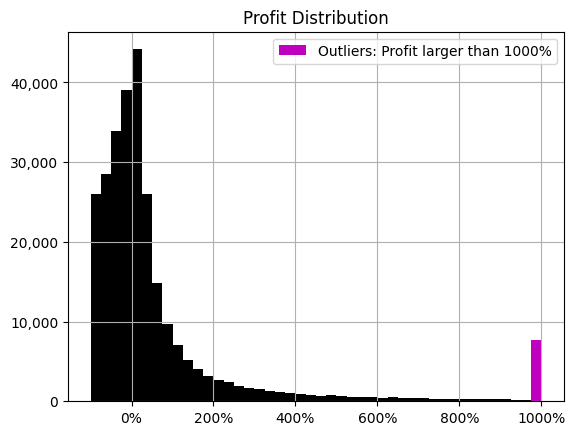

In [64]:
data = nft_trades["profit_usd"]
lower = -1
upper = 10


n, bins, patches = plt.hist(
    data, range=(lower, upper), bins=44, color="black", stacked=True
)


n_upper_outliers = (data > upper).sum()
patches[-1].set_height(patches[-1].get_height() + n_upper_outliers)
patches[-1].set_facecolor("m")
patches[-1].set_label(f"Outliers: Profit larger than {upper*100}%")

plt.legend()
plt.title("Profit Distribution")
plt.grid()
# plt.ticklabel_format(axis="x", style="scientific", useOffset=False)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ",")))
plt.savefig("figures/returns_hist.png")

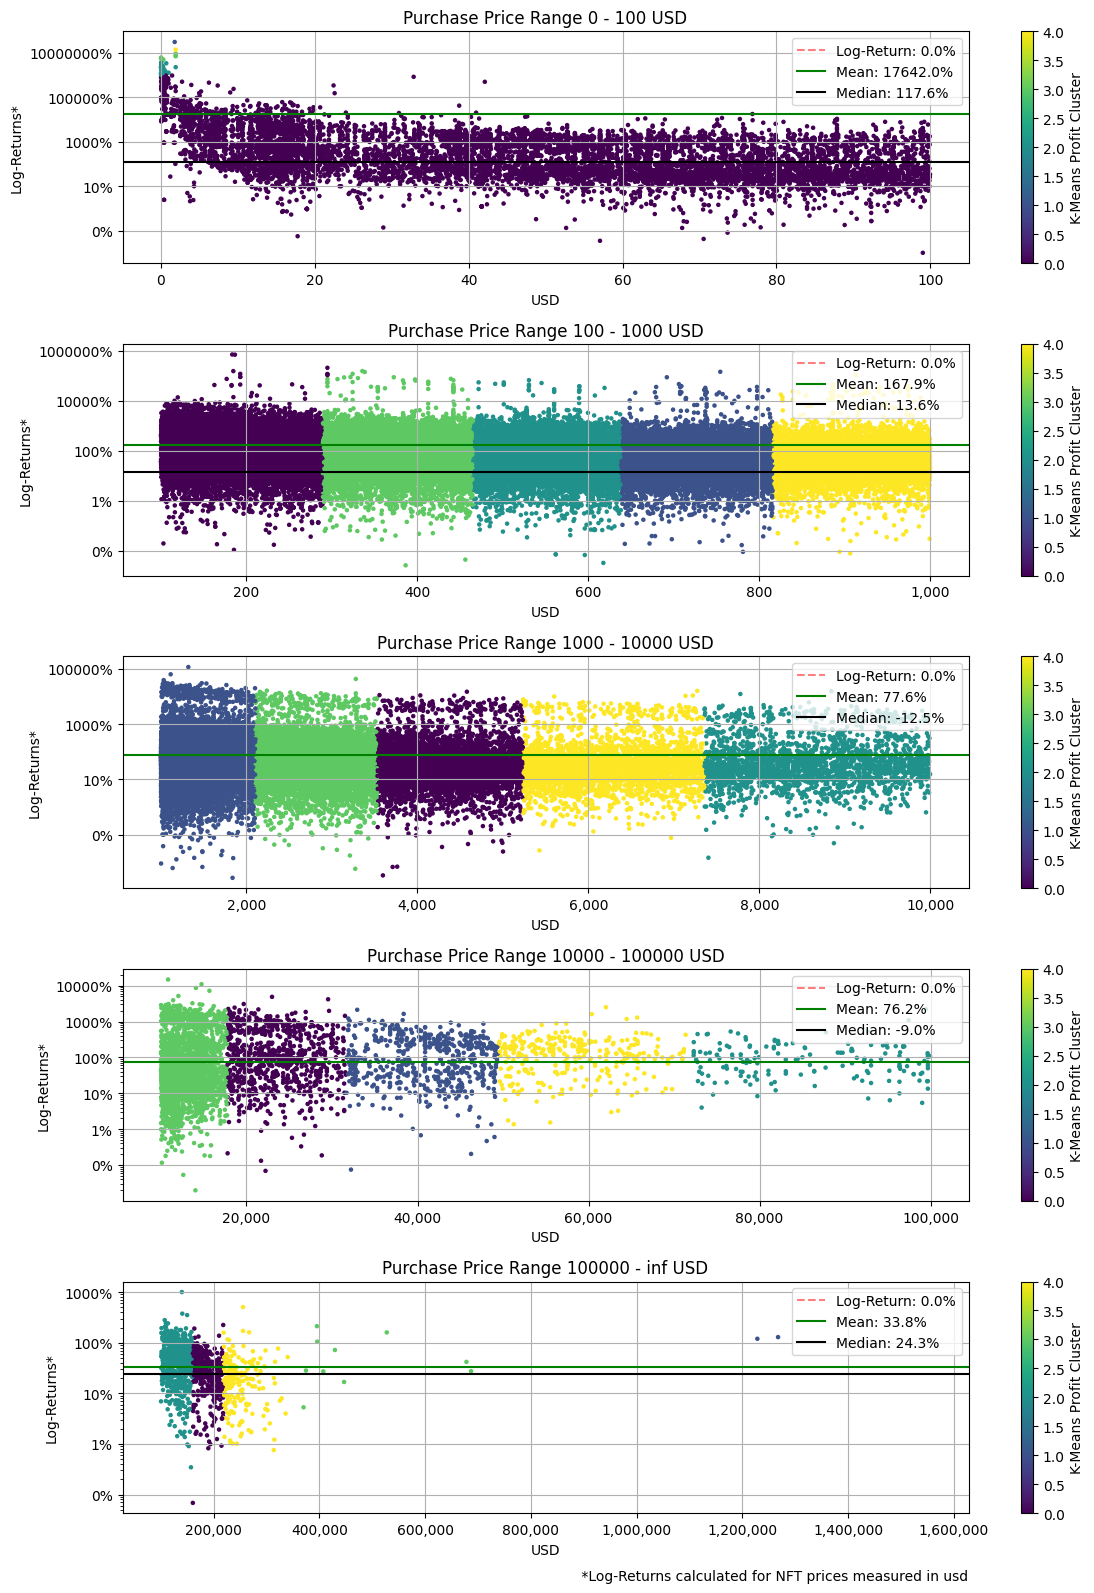

In [71]:
splits = [100, 1000, 10000, 100000, np.inf]
currency = "usd"

plot_figure_profit_per_price(splits, currency, nft_trades)

In [ ]:
collection_grouped = (
    nft_trades[["collection", "profit_usd"]]
    .groupby("collection")
    .agg(["min", "max", "sum", "count", "mean"])
    .round(4)["profit_usd"]
    .sort_values("count", ascending=False)
    .reset_index()
    # .head(100)
)

ax = collection_grouped.plot.scatter(
    x="mean",
    y="count",
    marker=".",
    color="black",
    legend=True,
    ylabel="Trade Count",
    xlabel="Collections",
    logx=True,
)

ax1 = ax.twinx()

plt.grid()

plt.savefig("figures/profit_per_collection.png")
plt.show()

In [ ]:
address_grouped = (
    nft_trades[["from_address", "profit_usd"]]
    .groupby("from_address")
    .agg(["min", "max", "sum", "count", "mean"])
    .round(4)["profit_usd"]
    .sort_values("count", ascending=False)
    .reset_index()
    .head(100)
)

ax = address_grouped.plot.scatter(
    x="from_address",
    y="count",
    marker=".",
    color="black",
    legend=True,
    ylabel="Trade Count",
    xlabel="Addresses",
)

ax1 = ax.twinx()

address_grouped.plot.scatter(
    x="from_address",
    y="mean",
    color="black",
    xticks=[],
    xlabel="Addresses",
    ylabel="Mean Profit",
    title="Top 100 NFT Selling Addresses",
    marker="x",
    legend=True,
    secondary_y=True,
    ylim=(-1, 20),
    ax=ax1,
)
plt.grid()
plt.savefig("figures/profit_per_investor.png")
plt.show()

In [ ]:
address_grouped = (
    nft_trades[["from_address", "profit_usd"]]
    .groupby("from_address")
    .agg(["min", "max", "sum", "count", "mean", "median"])
    .round(4)["profit_usd"]
    .sort_values("count", ascending=False)
    .reset_index()
)

ax = address_grouped.plot.scatter(
    x="median",
    y="count",
    marker=".",
    color="black",
    legend=True,
    ylabel="Trade Count per Address",
    xlabel="Median Profit per Address",
    ylim=(0, 200),
    xlim=(-1, 10000),
    logx=True,
    title="Zero Correlation between Trade Count and Profit",
)
plt.axvline(nft_trades["profit_usd"].median(), color="red")
plt.axvline(nft_trades["profit_usd"].mean(), color="green")

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid()
plt.savefig("figures/profit_per_investor.png")
plt.show()

print(f"Median: {nft_trades.profit_usd.median()}, Mean: {nft_trades.profit_usd.mean()}")

In [ ]:
round(address_grouped["mean"].corr(address_grouped["count"]), 4)

In [ ]:
(address_grouped["median"] / address_grouped["count"]).sort_values().hist()

In [ ]:
nft_trades["sell_price_usd"].median()

In [ ]:
nft_trades["purchase_price_usd"].describe()

In [ ]:
address_grouped[""]

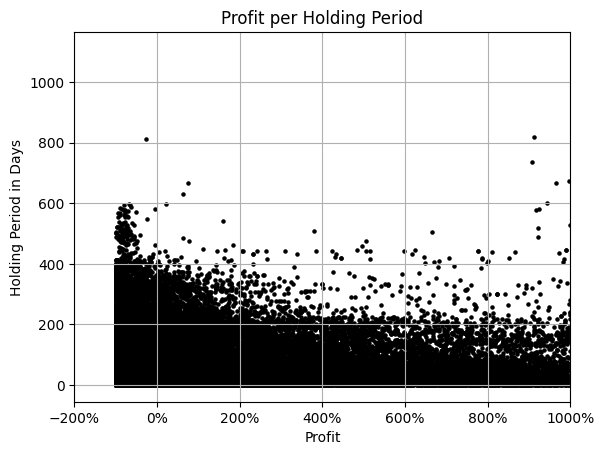

In [62]:
plot_df = (
    nft_trades[["holding_period", "profit_usd"]]
    .groupby("holding_period")
    .agg(["min", "max", "sum", "count", "mean", "median"])
    .round(4)["profit_usd"]
    .reset_index()
)
# y_pred = KMeans(5, n_init=100, max_iter=1000, algorithm="elkan")
# y_pred.fit(plot_df[["mean"]])
# plot_df["Cluster"] = y_pred.labels_.astype(float)
ax = nft_trades.plot.scatter(
    x="profit_usd",
    y="holding_period",
    # c="Cluster",
    ylabel="Holding Period in Days",
    color="Black",
    xlabel="Profit",
    title="Profit per Holding Period",
    grid=True,
    xlim=(-2, 10),
    marker=".",
    # logx=True
)
# plt.axvline(nft_trades["profit_usd"].median())
# plt.axvline(0)
# plt.axvline(-1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

In [ ]:
nft_trades["profit_usd"].median()

#### ToDo:

- Liquidität
- Erwerbbarkeit
- Handlichkeit der Wallets (Usability)
- Erwartete Rendite vs Vola
- Steuern
- Kosten Gas Fees --> always below 0.001 USD
- Diversifikation innerhalb NFTs -> Korrelationsmatrix

# Get Collections for Appendix

In [ ]:
collections_to_latex(nft_trades)